In [1]:
# Imports
import gc
import os
import subprocess
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import psutil
import py7zr
import seaborn as sns
import statsmodels.formula.api as smf
from lxml import etree
from scipy import stats
from sklearn.linear_model import LassoCV

## Import data from large archive files:
https://archive.org/download/stackexchange

In [ ]:
def log_memory_usage(label=""):
    """Log current memory usage"""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory usage {label}: {mem_info.rss / 1024 / 1024:.2f} MB")


def process_xml_in_7z(
    archive_path,
    batch_size=5000,
    start_date=None,
    end_date=None,
    record_tag="row",
    chunk_to_disk=False,
    temp_dir="data/temp/",
    micro_batch_size=100,
):
    """
    Process an XML file within a 7z archive efficiently, optimized for Stack Exchange data.
    Only filters by non-empty titles and date range.

    Args:
        archive_path (str): Path to the .7z archive
        batch_size (int): Number of elements to process in each batch
        start_date (str): Optional start date in format 'YYYY-MM-DD'
        end_date (str): Optional end date in format 'YYYY-MM-DD'
        record_tag (str): XML tag name for records to process (default: "row")
        chunk_to_disk (bool): Whether to write intermediate chunks to disk (for very large files)
        temp_dir (str): Directory to store temporary chunk files if chunking is enabled
        micro_batch_size (int): Size of micro-batches for more frequent memory clearing

    Returns:
        pl.DataFrame: Polars DataFrame containing the processed data with all columns
    """
    print(f"Starting processing of {archive_path}")
    log_memory_usage("at start")

    # Convert date strings to datetime objects if provided
    start_dt = datetime.strptime(start_date, "%Y-%m-%d") if start_date else None
    end_dt = datetime.strptime(end_date, "%Y-%m-%d") if end_date else None

    # Get the filename inside the archive
    xml_filename = None
    with py7zr.SevenZipFile(archive_path, mode="r") as archive:
        file_list = archive.getnames()
        if not file_list:
            raise ValueError("No files found in archive")

        # Look for Posts.xml
        for filename in file_list:
            if filename.endswith("Posts.xml"):
                xml_filename = filename
                break

        if not xml_filename:
            # Just use the first file if Posts.xml isn't found
            xml_filename = file_list[0]

    print(f"Processing XML file: {xml_filename}")

    # Use 7z command-line tool to pipe the content without extraction
    cmd = ["7z", "e", "-so", archive_path, xml_filename]
    print(f"Executing: {' '.join(cmd)}")

    # Initialize tracking variables
    all_data = []
    micro_batch = []
    total_processed = 0
    total_skipped = 0
    chunk_files = []
    chunk_count = 0

    # Create temp directory if chunking is enabled
    if chunk_to_disk:
        Path(temp_dir).mkdir(parents=True, exist_ok=True)

    # Start the extraction process with controlled buffer size
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        bufsize=1024 * 1024,  # 1MB buffer
    )

    try:
        # Create iterator with lxml
        context = etree.iterparse(
            process.stdout,
            events=("end",),
            tag=record_tag,
            recover=True,
            huge_tree=True,
            remove_blank_text=True,
            remove_comments=True,
            remove_pis=True,
        )

        for _, elem in context:
            # First, check title - our primary filter
            title = elem.get("Title")
            if not title or title.strip() == "":
                # For some post types like answers, missing Title is normal
                # Only skip if it's a question (PostTypeId=1)
                post_type = elem.get("PostTypeId")
                if post_type == "1":
                    total_skipped += 1
                    elem.clear()
                    continue

            # Date filter (if specified)
            skip_record = False
            if start_dt or end_dt:
                date_attr = elem.get("CreationDate")
                if date_attr:
                    try:
                        # Parse date for filtering
                        if "T" in date_attr:
                            record_date = datetime.fromisoformat(
                                date_attr.replace("Z", "+00:00")
                            )
                        else:
                            record_date = datetime.strptime(date_attr, "%Y-%m-%d")

                        # Skip if out of date range
                        if (start_dt and record_date.date() < start_dt.date()) or (
                            end_dt and record_date.date() > end_dt.date()
                        ):
                            skip_record = True
                    except (ValueError, TypeError) as e:
                        print(f"Warning: Invalid date format '{date_attr}', error: {e}")

            if skip_record:
                total_skipped += 1
                elem.clear()
                continue

            # If we reach here, the record should be included
            # Extract ALL attributes - no filtering of columns
            row_data = {
                k: str(v) if v is not None else None for k, v in elem.attrib.items()
            }

            # Add to micro-batch
            micro_batch.append(row_data)
            total_processed += 1

            # Clear element to free memory
            elem.clear()
            # Also eliminate previous siblings to keep memory usage low
            while elem.getprevious() is not None:
                del elem.getparent()[0]

            # Process in micro-batches to avoid memory spikes
            if len(micro_batch) >= micro_batch_size:
                all_data.extend(micro_batch)
                micro_batch = []  # Free the micro-batch memory

                # If we've reached full batch size, process the batch
                if len(all_data) >= batch_size:
                    if chunk_to_disk:
                        # Create and save dataframe chunk
                        chunk_df = pl.from_dicts(
                            all_data, infer_schema_length=min(100000, len(all_data))
                        )
                        chunk_file = f"{temp_dir}/chunk_{chunk_count}.parquet"

                        # Write to parquet with compression
                        chunk_df.write_parquet(chunk_file, compression="zstd")
                        chunk_files.append(chunk_file)
                        chunk_count += 1

                        # Clear memory
                        del chunk_df
                        all_data = []  # Free memory
                        gc.collect()

                    if total_processed % 50000 == 0:
                        print(
                            f"Processed {total_processed:,} records, skipped {total_skipped:,}"
                        )
                        log_memory_usage("during processing")

        # Process any remaining data in the micro-batch
        if micro_batch:
            all_data.extend(micro_batch)
            micro_batch = []  # Free memory

        # Process final batch if there's any data left
        if all_data and chunk_to_disk:
            chunk_df = pl.from_dicts(
                all_data, infer_schema_length=min(100000, len(all_data))
            )
            chunk_file = f"{temp_dir}/chunk_{chunk_count}.parquet"
            chunk_df.write_parquet(chunk_file, compression="zstd")
            chunk_files.append(chunk_file)
            del chunk_df
            all_data = []  # Free memory
            gc.collect()

        print("All records processed. Creating final DataFrame...")

    finally:
        # Terminate the subprocess if it's still running
        if process.poll() is None:
            process.terminate()
            process.wait(timeout=5)  # Wait for process to terminate

    # Final results processing
    print(
        f"Completed. Total processed: {total_processed:,}, skipped: {total_skipped:,}"
    )

    if chunk_to_disk and chunk_files:
        print(f"Reading and combining {len(chunk_files)} chunks from disk")

        # For very large datasets, combine chunks incrementally to prevent memory overload
        if len(chunk_files) > 0:
            # Start with the first chunk
            result_df = pl.read_parquet(chunk_files[0])

            # Process chunks in groups to limit memory usage
            for i, file in enumerate(chunk_files[1:], 1):
                if i % 10 == 0:
                    print(f"Combining chunk {i}/{len(chunk_files)}")
                    log_memory_usage(f"after {i} chunks")

                # Read the chunk
                try:
                    next_df = pl.read_parquet(file)

                    # Combine with result
                    result_df = pl.concat([result_df, next_df], how="diagonal_relaxed")

                    # Release memory
                    del next_df
                    if i % 5 == 0:  # Periodically collect garbage
                        gc.collect()
                except Exception as e:
                    print(f"Error reading chunk {file}: {e}")
                    continue

            # Clean up temporary files if needed
            # Uncomment if you want to delete the chunk files after processing
            # for file in chunk_files:
            #     try:
            #         os.remove(file)
            #     except:
            #         pass

            print(f"Final dataframe size: {len(result_df):,} rows")
            log_memory_usage("after combining all chunks")
            return result_df
        else:
            print("No chunks were created. Returning empty DataFrame.")
            return pl.DataFrame()
    else:
        # Process in-memory data
        if all_data:
            print(f"Creating DataFrame from {len(all_data):,} records...")
            df = pl.from_dicts(all_data, infer_schema_length=min(100000, len(all_data)))
            # Clear the all_data list to free memory
            all_data = []
            gc.collect()
            return df
        else:
            return pl.DataFrame()


def process_stack_data(
    archive_path,
    output_file="stack_data.parquet",
    start_date=None,
    end_date=None,
    batch_size=5000,
    large_file=False,
    split_output=False,
    max_rows_per_file=1000000,
    temp_dir=None,
):
    """
    High-level function to process Stack Exchange XML data from any community.
    Keeps all columns and only filters out empty titles (for questions) and by date.

    Args:
        archive_path (str): Path to the 7z archive containing XML data
        output_file (str): Path to save the output parquet file
        start_date (str): Optional start date filter in 'YYYY-MM-DD' format
        end_date (str): Optional end date filter in 'YYYY-MM-DD' format
        batch_size (int): Batch size for processing
        large_file (bool): If True, use disk-based chunking for very large files
        split_output (bool): If True, split output into multiple files for memory efficiency
        max_rows_per_file (int): Maximum rows per file when splitting output
        temp_dir (str): Directory to store temporary chunk files

    Returns:
        pl.DataFrame or None: Processed data, or None if split_output is True
    """
    print(f"Processing {archive_path}")
    log_memory_usage("before processing")

    # Set a community-specific temp directory if not provided
    if temp_dir is None:
        community_name = os.path.basename(archive_path).split(".")[0]
        temp_dir = f"data/temp/{community_name}/"

    # Always use chunk_to_disk for large_file processing
    df = process_xml_in_7z(
        archive_path=archive_path,
        batch_size=batch_size,
        start_date=start_date,
        end_date=end_date,
        chunk_to_disk=large_file,
        temp_dir=temp_dir,
    )

    if not df.is_empty():
        print(f"Found {len(df):,} records")
        print(f"Columns: {df.columns}")

        # For very large result sets, split the output into multiple files
        if split_output and len(df) > max_rows_per_file:
            output_base, output_ext = output_file.rsplit(".", 1)
            num_files = (len(df) + max_rows_per_file - 1) // max_rows_per_file

            print(
                f"Splitting output into {num_files} files with max {max_rows_per_file:,} rows each"
            )

            for i in range(num_files):
                start_idx = i * max_rows_per_file
                end_idx = min((i + 1) * max_rows_per_file, len(df))

                # Get slice of dataframe
                part_df = df.slice(start_idx, end_idx - start_idx)

                # Save to file
                part_file = f"{output_base}_part{i + 1}.{output_ext}"
                part_df.write_parquet(part_file, compression="zstd")
                print(f"Saved part {i + 1}/{num_files} to {part_file}")

                # Release memory
                del part_df
                gc.collect()

            # Free the main dataframe memory
            del df
            gc.collect()
            log_memory_usage("after saving split files")
            return None  # Return None since we've split the output
        else:
            # Save to single parquet file
            print(f"Saving data to {output_file}")
            df.write_parquet(output_file, compression="zstd")
            print(f"Data saved to {output_file}")
            log_memory_usage("after saving")
            return df
    else:
        print("No matching records found")
        return df

In [ ]:
df_law = process_stack_data(
    "data/law.stackexchange.com.7z",
    output_file="data/law/law.parquet",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/law.stackexchange.com.7z for records with non-empty titles
Executing: 7z e -so data/law.stackexchange.com.7z Posts.xml
Completed. Total processed: 11325, skipped: 62019
Found 11325 records with non-empty titles
Columns: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'ClosedDate', 'ContentLicense', 'LastEditorDisplayName', 'AcceptedAnswerId', 'OwnerDisplayName', 'FavoriteCount']
Data saved to data/law/law.parquet


In [ ]:
chunks = []
# List files in directory
files = os.listdir("data/temp/")
for file in files:
    if file.endswith(".parquet"):
        chunk = pl.read_parquet(f"data/temp/{file}")
        chunks.append(chunk)

In [15]:
def pl_grouping_wk(df: pl.DataFrame) -> pl.DataFrame:
    df = (
        df.with_columns(
            pl.col("CreationDate").cast(pl.Datetime),
            pl.col("LastActivityDate").cast(pl.Datetime),
        )
        .group_by(pl.col("CreationDate").dt.truncate("1w"))
        .agg(pl.len().alias("Count"))
        .sort("CreationDate")
    )
    return df

In [ ]:
df_ac = process_stack_data(
    "data/academia.stackexchange.com.7z",
    output_file="data/academia/academia.parquet",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/academia.stackexchange.com.7z for records with non-empty titles
Executing: 7z e -so data/academia.stackexchange.com.7z Posts.xml
Completed. Total processed: 9992, skipped: 138814
Found 9992 records with non-empty titles
Columns: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'ContentLicense', 'AcceptedAnswerId', 'LastEditorUserId', 'LastEditDate', 'ClosedDate', 'FavoriteCount', 'OwnerDisplayName', 'LastEditorDisplayName', 'CommunityOwnedDate']
Data saved to data/academia/academia.parquet


In [6]:
df_ph = process_stack_data(
    "data/physics.stackexchange.com.7z",
    output_file="data/physics/physics.parquet",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/physics.stackexchange.com.7z
Memory usage before processing: 2882.79 MB
Starting processing of data/physics.stackexchange.com.7z
Memory usage at start: 2882.79 MB
Processing XML file: Posts.xml
Executing: 7z e -so data/physics.stackexchange.com.7z Posts.xml
Processed 100,000 records, skipped 428,822
Memory usage during processing: 2885.63 MB
All records processed. Creating final DataFrame...
Completed. Total processed: 148,479, skipped: 428,822
Reading and combining 2 chunks from disk
Final dataframe size: 148,479 rows
Memory usage after combining all chunks: 3077.26 MB
Found 148,479 records
Columns: ['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'ContentLicense', 'ParentId', 'LastEditorUserId', 'LastEditDate', 'ClosedDate', 'CommunityOwnedDate', 'OwnerDisplayName', 'LastEditorDisplayName', 'FavoriteCount']
Saving data to data/physics/physics.parque

In [31]:
df_su = process_stack_data(
    "data/superuser/superuser.com.7z",
    output_file="data/superuser/superuser.parquet",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/superuser/superuser.com.7z
Memory usage before processing: 10063.19 MB
Starting processing of data/superuser/superuser.com.7z
Memory usage at start: 10063.19 MB
Processing XML file: Posts.xml
Executing: 7z e -so data/superuser/superuser.com.7z Posts.xml
Processed 100,000 records, skipped 1,100,201
Memory usage during processing: 10490.81 MB
All records processed. Creating final DataFrame...
Completed. Total processed: 145,217, skipped: 1,100,201
Reading and combining 2 chunks from disk
Final dataframe size: 145,217 rows
Memory usage after combining all chunks: 10545.52 MB
Found 145,217 records
Columns: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'ContentLicense', 'LastEditorUserId', 'LastEditDate', 'ParentId', 'AcceptedAnswerId', 'ClosedDate', 'OwnerDisplayName', 'CommunityOwnedDate', 'FavoriteCount', 'LastEditorDisplayName']
Saving data to data/superuser/superuser.

In [33]:
df_au = process_stack_data(
    "data/askubuntu/askubuntu.com.7z",
    output_file="data/askubuntu/askubuntu.parquet",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/askubuntu/askubuntu.com.7z
Memory usage before processing: 10552.12 MB
Starting processing of data/askubuntu/askubuntu.com.7z
Memory usage at start: 10552.12 MB
Processing XML file: Posts.xml
Executing: 7z e -so data/askubuntu/askubuntu.com.7z Posts.xml
Processed 100,000 records, skipped 815,642
Memory usage during processing: 10572.57 MB
All records processed. Creating final DataFrame...
Completed. Total processed: 129,469, skipped: 815,642
Reading and combining 2 chunks from disk
Final dataframe size: 129,469 rows
Memory usage after combining all chunks: 10695.32 MB
Found 129,469 records
Columns: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'ClosedDate', 'ContentLicense', 'ParentId', 'LastEditorUserId', 'LastEditDate', 'FavoriteCount', 'OwnerDisplayName', 'LastEditorDisplayName', 'AcceptedAnswerId', 'CommunityOwnedDate']
Saving data to data/askubuntu/askubuntu.parq

In [4]:
df_math = process_stack_data(
    archive_path="data/math.stackexchange.com.7z",
    output_file="data/math/math.parquet",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/math.stackexchange.com.7z
Memory usage before processing: 112.74 MB
Starting processing of data/math.stackexchange.com.7z
Memory usage at start: 112.74 MB
Processing XML file: Posts.xml
Executing: 7z e -so data/math.stackexchange.com.7z Posts.xml
Processed 100,000 records, skipped 3,141,123
Memory usage during processing: 1010.12 MB
Processed 200,000 records, skipped 3,141,123
Memory usage during processing: 1062.99 MB
Processed 300,000 records, skipped 3,141,123
Memory usage during processing: 1088.12 MB
Processed 400,000 records, skipped 3,141,123
Memory usage during processing: 1110.93 MB
Processed 500,000 records, skipped 3,141,123
Memory usage during processing: 1136.40 MB
Processed 600,000 records, skipped 3,141,123
Memory usage during processing: 1160.92 MB
All records processed. Creating final DataFrame...
Completed. Total processed: 651,312, skipped: 3,141,123
Reading and combining 7 chunks from disk
Final dataframe size: 651,312 rows
Memory usage after combini

In [ ]:
df = process_stack_data(
    "data/stackoverflow.com-Posts.7z",
    batch_size=100000,
    start_date="2021-01-01",
    end_date="2024-12-31",
    large_file=True,
)

Processing data/stackoverflow.com-Posts.7z for records with non-empty titles
Executing: 7z e -so data/stackoverflow.com-Posts.7z Posts.xml
Processed 100000 records, skipped 50941048
Processed 200000 records, skipped 51071575
Processed 300000 records, skipped 51199892
Processed 400000 records, skipped 51327192
Processed 500000 records, skipped 51455032
Processed 600000 records, skipped 51581951
Processed 700000 records, skipped 51711507
Processed 800000 records, skipped 51841194
Processed 900000 records, skipped 51969489
Processed 1000000 records, skipped 52100047
Processed 1100000 records, skipped 52232351
Processed 1200000 records, skipped 52362887
Processed 1300000 records, skipped 52492746
Processed 1400000 records, skipped 52619123
Processed 1500000 records, skipped 52746017
Processed 1600000 records, skipped 52876885
Processed 1700000 records, skipped 53005148
Processed 1800000 records, skipped 53130551
Processed 1900000 records, skipped 53254833
Processed 2000000 records, skipped

: 

## Testing parallel trends assumption

In [2]:
# Set seaborn style
sns.set_theme()  # (style="whitegrid")
warnings.filterwarnings("ignore")


# 1. Data Preparation Function
def prepare_forum_data(forum_df, forum_name):
    """
    Prepare and standardize data from a Stack Exchange forum.

    Parameters:
    -----------
    forum_df : polars.DataFrame
        DataFrame containing Posts.xml data for a forum
    forum_name : str
        Name of the forum

    Returns:
    --------
    polars.DataFrame
        Standardized dataframe with question counts
    """
    # Filter to questions only (PostTypeId = 1)
    questions_df = forum_df.filter(pl.col("PostTypeId") == "1")

    # Convert CreationDate to datetime if it's not already
    if questions_df["CreationDate"].dtype != pl.Datetime:
        questions_df = questions_df.with_columns(
            pl.col("CreationDate").str.strptime(
                pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f"
            )
        )

    # Extract basic date components
    questions_df = questions_df.with_columns(
        [
            pl.col("CreationDate").dt.date().alias("date"),
            pl.col("CreationDate").dt.year().alias("year"),
            pl.col("CreationDate").dt.month().alias("month"),
            pl.col("CreationDate").dt.weekday().alias("day_of_week"),
            # ISO week of year
            pl.col("CreationDate").dt.week().alias("week"),
        ]
    )

    # Create year-week identifier
    questions_df = questions_df.with_columns(
        (pl.col("year") * 100 + pl.col("week")).alias("yearweek")
    )

    # Add forum identifier
    questions_df = questions_df.with_columns(pl.lit(forum_name).alias("forum"))

    # Aggregate to weekly level
    weekly_df = questions_df.group_by(["yearweek", "year", "week", "forum"]).agg(
        [
            pl.count().alias("question_count"),
            pl.col("date").min().alias("week_start"),
            # Optional: additional metrics if you have them
            pl.col("Score").mean().alias("avg_score"),
            pl.col("ViewCount").mean().alias("avg_views"),
            pl.col("CommentCount").mean().alias("avg_comments"),
        ]
    )

    return weekly_df


# 2. Load and prepare all forum data
# Load data
df_so = pl.read_parquet("data/stackoverflow/stackoverflow_filtered_data.parquet")
stackoverflow_weekly = prepare_forum_data(df_so, "Stack Overflow")
# Clean memory
del df_so
gc.collect()
df_math = pl.read_parquet("data/math/math.parquet")
df_physics = pl.read_parquet("data/physics/physics.parquet")
df_superuser = pl.read_parquet("data/superuser/superuser.parquet")
df_askubuntu = pl.read_parquet("data/askubuntu/askubuntu.parquet")
math_weekly = prepare_forum_data(df_math, "Mathematics")
del df_math
physics_weekly = prepare_forum_data(df_physics, "Physics")
del df_physics
superuser_weekly = prepare_forum_data(df_superuser, "Superuser")
del df_superuser
askubuntu_weekly = prepare_forum_data(df_askubuntu, "Askubuntu")
del df_askubuntu
gc.collect()


0

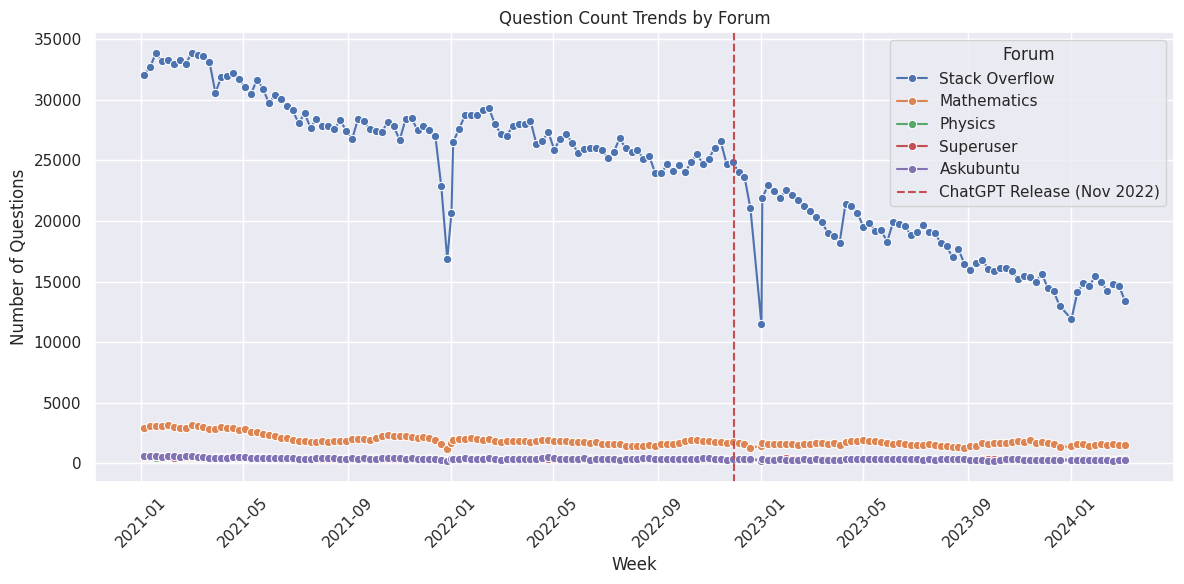

In [3]:
# 3. Combine all forum data
all_forums_weekly = pl.concat(
    [
        stackoverflow_weekly,
        math_weekly,
        physics_weekly,
        superuser_weekly,
        askubuntu_weekly,
    ]
)

# 4. Visualize the data to check for parallel trends
plt.figure(figsize=(12, 6))
treatment_date = datetime(2022, 11, 30)


# Drop first week and last two as they are non-representative
all_forums_weekly = all_forums_weekly.filter(
    pl.col("week_start") > datetime(2021, 1, 1),
    pl.col("week_start") <= datetime(2024, 3, 4),
)
# Convert to pandas for plotting with seaborn
all_forums_weekly_pd = all_forums_weekly.to_pandas()

# Plot trends
sns.lineplot(
    data=all_forums_weekly,
    x="week_start",
    y="question_count",
    hue="forum",
    marker="o",
)

# Add vertical line for treatment date
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Question Count Trends by Forum")
plt.xlabel("Week")
plt.ylabel("Number of Questions")
plt.legend(title="Forum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Enhanced DiD

In [4]:
# 1. Normalize data to address scale differences
def prepare_forum_data_normalized(forum_df, forum_name):
    """
    Prepare and standardize data from a Stack Exchange forum with normalization.
    """
    # Filter to questions only (PostTypeId = 1)
    questions_df = forum_df.filter(pl.col("PostTypeId") == "1")

    # Convert CreationDate to datetime if it's not already
    if questions_df["CreationDate"].dtype != pl.Datetime:
        questions_df = questions_df.with_columns(
            pl.col("CreationDate").str.strptime(
                pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f"
            )
        )

    # Extract basic date components
    questions_df = questions_df.with_columns(
        [
            pl.col("CreationDate").dt.date().alias("date"),
            pl.col("CreationDate").dt.year().alias("year"),
            pl.col("CreationDate").dt.month().alias("month"),
            pl.col("CreationDate").dt.weekday().alias("day_of_week"),
            pl.col("CreationDate").dt.week().alias("week"),
        ]
    )

    # Create year-week identifier
    questions_df = questions_df.with_columns(
        (pl.col("year") * 100 + pl.col("week")).alias("yearweek")
    )

    # Add forum identifier
    questions_df = questions_df.with_columns(pl.lit(forum_name).alias("forum"))

    # Aggregate to weekly level
    weekly_df = questions_df.group_by(["yearweek", "year", "week", "forum"]).agg(
        [
            pl.count().alias("question_count"),
            pl.col("date").min().alias("week_start"),
            pl.col("Score").mean().alias("avg_score"),
            pl.col("ViewCount").mean().alias("avg_views"),
            pl.col("CommentCount").mean().alias("avg_comments"),
        ]
    )

    return weekly_df


# 2. Addressing non-parallel trends: Log transformation for question counts
def transform_for_parallel(all_forums_weekly):
    """Apply transformations to help achieve more parallel trends"""
    # First, apply log transformation for question count
    transformed_df = all_forums_weekly.with_columns(
        pl.col("question_count")
        .map_elements(lambda x: np.log1p(x))
        .alias("log_question_count")
    )

    # Get all unique forums
    forums = transformed_df["forum"].unique().to_list()

    # Create indexed count expressions for each forum
    indexed_exprs = []
    for forum in forums:
        # Get the first period value for this forum
        first_value = (
            transformed_df.filter(pl.col("forum") == forum)
            .sort("week_start")
            .select(pl.col("question_count"))
            .head(1)
            .item()
        )

        # Add conditional expression for this forum
        indexed_exprs.append(
            pl.when(pl.col("forum") == forum)
            .then(100 * pl.col("question_count") / first_value)
            .otherwise(0)  # Will be overwritten by other forum conditions
        )

    # Combine all expressions with sum() to create the indexed_count column
    if indexed_exprs:
        final_expr = indexed_exprs[0]
        for expr in indexed_exprs[1:]:
            final_expr = final_expr + expr

        # Add the indexed column
        transformed_df = transformed_df.with_columns(final_expr.alias("indexed_count"))

    return transformed_df


# 3. Visualize different transformations to check for better parallel trends
def visualize_transformations(transformed_data):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    treatment_date = datetime(2022, 11, 30)

    # Convert to pandas for easier plotting with seaborn
    transformed_data_pd = transformed_data.to_pandas()

    # Plot 1: Raw question counts
    sns.lineplot(
        data=transformed_data_pd,
        x="week_start",
        y="question_count",
        hue="forum",
        marker="o",
        ax=axes[0],
    )
    axes[0].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[0].set_title("Raw Question Counts")
    axes[0].set_ylabel("Number of Questions")
    # Place legend below the plot
    axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Plot 2: Log-transformed question counts
    sns.lineplot(
        data=transformed_data_pd,
        x="week_start",
        y="log_question_count",
        hue="forum",
        marker="o",
        ax=axes[1],
    )
    axes[1].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[1].set_title("Log-Transformed Question Counts")
    axes[1].set_ylabel("Log(Number of Questions + 1)")
    # Place legend below the plot
    axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Plot 3: Indexed question counts (first period = 100)
    sns.lineplot(
        data=transformed_data_pd,
        x="week_start",
        y="indexed_count",
        hue="forum",
        marker="o",
        ax=axes[2],
    )
    axes[2].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[2].set_title("Indexed Question Counts (First Period = 100)")
    axes[2].set_ylabel("Index (First Period = 100)")
    # Place legend below the plot
    axes[2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.45)
    plt.savefig("imgs/transformed_trends.svg")
    plt.show()

    return fig


# 4. Test for parallel trends with different transformations
def test_parallel_trends_transformed(transformed_data):
    """Test parallel trends assumption with different transformations"""
    # Convert to pandas for statsmodels
    transformed_data_pd = transformed_data.to_pandas()
    treatment_date = datetime(2022, 11, 30)

    # Filter to pre-treatment period
    pre_treatment = transformed_data_pd[
        transformed_data_pd["week_start"] <= treatment_date
    ].copy()

    # Create time trend variable
    pre_treatment["time_trend"] = pre_treatment.groupby("forum")["week_start"].rank()

    # Recode the forum variable to make Stack Overflow the reference
    pre_treatment["forum"] = pd.Categorical(
        pre_treatment["forum"],
        categories=[
            "Physics",
            "Stack Overflow",
            "Mathematics",
            "Superuser",
            "Askubuntu",
        ],
    )

    results = {}

    # Test raw counts
    formula_raw = "question_count ~ time_trend + forum + time_trend:forum"
    model_raw = smf.ols(formula_raw, data=pre_treatment).fit()
    results["Raw Counts"] = model_raw

    # Test log counts
    formula_log = "log_question_count ~ time_trend + forum + time_trend:forum"
    model_log = smf.ols(formula_log, data=pre_treatment).fit()
    results["Log Counts"] = model_log

    # Test indexed counts
    formula_idx = "indexed_count ~ time_trend + forum + time_trend:forum"
    model_idx = smf.ols(formula_idx, data=pre_treatment).fit()
    results["Indexed Counts"] = model_idx

    # Print summary of results
    print("Parallel Trends Tests for Different Transformations:")
    for name, model in results.items():
        print(f"\n{name}:")
        interactions = [var for var in model.params.index if "time_trend:forum" in var]
        p_values = model.pvalues[interactions]

        for var, p_val in zip(interactions, p_values):
            significance = (
                "Significant (non-parallel)"
                if p_val < 0.05
                else "Non-significant (parallel)"
            )
            print(f"{var}: p = {p_val:.4f} - {significance}")

    return results


# 5. Enhanced Synthetic Control Implementation
def enhanced_synthetic_control(
    outcome_var,
    control_vars,
    data,
    treatment_period,
    pre_treatment_mask,
    post_treatment_mask,
    outcome_transform=None,
):
    """
    Implements an enhanced synthetic control with several improvements:
    - Option for transformed outcome variable
    - Regularization strength selection
    - More robust placebo tests
    - Visualization of weights
    """
    # Apply transformation if specified
    if outcome_transform == "log":
        y_var = f"log_{outcome_var}"
    elif outcome_transform == "index":
        y_var = f"indexed_{outcome_var}"
    else:
        y_var = outcome_var

    # Extract pre-treatment data for fitting
    X_pre = data.loc[pre_treatment_mask, control_vars].values
    y_pre = data.loc[pre_treatment_mask, y_var].values

    # Test different regularization strengths
    alphas = np.logspace(-3, 1, 20)
    model = LassoCV(cv=5, alphas=alphas, positive=True, fit_intercept=True)
    model.fit(X_pre, y_pre)

    # Get weights
    weights = pd.Series(model.coef_, index=control_vars)

    # Predict counterfactual for all periods
    X_all = data.loc[:, control_vars].values
    y_counterfactual = model.predict(X_all)

    # Calculate treatment effects
    y_actual = data[y_var].values
    treatment_effects = y_actual - y_counterfactual

    # Calculate average treatment effect on the treated (ATT)
    att = np.mean(treatment_effects[post_treatment_mask])

    # Pre-treatment fit (R²)
    r2_pre = 1 - np.sum((y_pre - model.predict(X_pre)) ** 2) / np.sum(
        (y_pre - np.mean(y_pre)) ** 2
    )

    # Calculate MSPE (Mean Squared Prediction Error) for pre-treatment
    mspe_pre = np.mean((y_pre - model.predict(X_pre)) ** 2)

    # If using log transformation, calculate effects in original scale
    if outcome_transform == "log":
        # Convert predictions back to original scale
        y_actual_orig = np.exp(y_actual) - 1
        y_counterfactual_orig = np.exp(y_counterfactual) - 1
        treatment_effects_orig = y_actual_orig - y_counterfactual_orig
        att_orig = np.mean(treatment_effects_orig[post_treatment_mask])
    else:
        treatment_effects_orig = treatment_effects
        att_orig = att

    # More robust inference using placebo tests
    placebo_effects = []
    placebo_window = min(
        int(len(pre_treatment_mask) * 0.2), 10
    )  # Use last 20% or 10 periods

    if placebo_window > 5:  # Only if we have enough data
        for i in range(placebo_window):
            # Create a placebo treatment period
            placebo_mask = np.zeros(len(pre_treatment_mask), dtype=bool)
            placebo_mask[-placebo_window + i : -placebo_window + i + 1] = True

            # Only use earlier periods for training
            placebo_train = pre_treatment_mask & ~placebo_mask

            # Skip if not enough training data or empty test data
            if np.sum(placebo_train) < 10 or np.sum(placebo_mask) == 0:
                continue

            # Fit on earlier data
            X_placebo_train = data.loc[placebo_train, control_vars].values
            y_placebo_train = data.loc[placebo_train, y_var].values

            model_placebo = LassoCV(cv=5, positive=True, fit_intercept=True)
            model_placebo.fit(X_placebo_train, y_placebo_train)

            # Get effect on placebo period
            X_placebo_test = data.loc[placebo_mask, control_vars].values
            y_placebo_test = data.loc[placebo_mask, y_var].values

            if X_placebo_test.shape[0] == 0:
                continue

            y_placebo_pred = model_placebo.predict(X_placebo_test)

            placebo_effect = np.mean(y_placebo_test - y_placebo_pred)
            placebo_effects.append(placebo_effect)

    placebo_effects = np.array(placebo_effects)
    se = np.std(placebo_effects) if len(placebo_effects) > 0 else np.nan

    # Calculate p-value from placebo distribution
    if len(placebo_effects) > 0:
        p_value = np.mean(np.abs(placebo_effects) >= np.abs(att))
    else:
        p_value = np.nan

    return {
        "weights": weights,
        "counterfactual": y_counterfactual,
        "effects": treatment_effects,
        "effects_orig": treatment_effects_orig,
        "att": att,
        "att_orig": att_orig,
        "se": se,
        "p_value": p_value,
        "r2_pre": r2_pre,
        "mspe_pre": mspe_pre,
        "placebo_effects": placebo_effects,
        "selected_alpha": model.alpha_,
    }


# 6. Visualize synthetic control results
def visualize_synthetic_control(data, result, outcome_forum, transformation=None):
    """
    Create comprehensive visualization of synthetic control results with the new column naming scheme.

    Parameters:
    -----------
    data : pandas.DataFrame
        Pivoted dataframe with transformed columns
    result : dict
        Results from enhanced_synthetic_control
    outcome_forum : str
        Name of the forum being analyzed (e.g., "Stack Overflow")
    transformation : str, optional
        Type of transformation applied ('log', 'index', or None)

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the visualizations
    """
    treatment_date = datetime(2022, 11, 30)

    # Determine column names based on transformation
    if transformation == "log":
        plot_var = f"{outcome_forum}_log_question_count"
        counterfactual = result["counterfactual"]
        effects = result["effects"]
        y_label = "Log(Number of Questions)"
    elif transformation == "index":
        plot_var = f"{outcome_forum}_indexed_count"
        counterfactual = result["counterfactual"]
        effects = result["effects"]
        y_label = "Index (First Period = 100)"
    else:
        plot_var = outcome_forum
        counterfactual = result["counterfactual"]
        effects = result["effects"]
        y_label = "Number of Questions"

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    # Plot 1: Actual vs Synthetic
    axes[0].plot(
        data["week_start"], data[plot_var], "b-", label=f"Actual {outcome_forum}"
    )
    axes[0].plot(data["week_start"], counterfactual, "g--", label="Synthetic Control")
    axes[0].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )

    # Shade post-treatment period
    post_treatment_idx = data["week_start"] > treatment_date
    min_date = data["week_start"].min()
    max_date = data["week_start"].max()

    axes[0].axvspan(
        treatment_date, max_date, alpha=0.2, color="gray", label="Post-Treatment"
    )
    axes[0].set_title(
        f"Synthetic Control: {outcome_forum} vs. Synthetic {outcome_forum}"
    )
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel(y_label)
    axes[0].legend()

    # Plot 2: Gap (Treatment Effect)
    axes[1].plot(data["week_start"], effects, "b-")
    axes[1].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[1].axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Add average treatment effect line
    axes[1].axhline(
        y=result["att"],
        color="g",
        linestyle="--",
        label=f"Avg. Treatment Effect: {result['att']:.2f}",
    )

    # Add confidence interval
    if not np.isnan(result["se"]):
        ci_lower = result["att"] - 1.96 * result["se"]
        ci_upper = result["att"] + 1.96 * result["se"]
        axes[1].fill_between(
            data.loc[post_treatment_idx, "week_start"],
            ci_lower,
            ci_upper,
            color="g",
            alpha=0.2,
            label=f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]",
        )

    axes[1].set_title(f"Gap Between {outcome_forum} and Synthetic Control")
    axes[1].set_xlabel("Week")
    axes[1].set_ylabel(f"Difference in {y_label}")
    axes[1].legend()

    # Plot 3: Weights visualization
    weights = result["weights"].sort_values(ascending=False)

    # Extract forum names from the potentially transformed column names
    weight_labels = []
    for col in weights.index:
        if "_log_question_count" in col:
            weight_labels.append(col.replace("_log_question_count", ""))
        elif "_indexed_count" in col:
            weight_labels.append(col.replace("_indexed_count", ""))
        else:
            weight_labels.append(col)

    colors = plt.cm.viridis(np.linspace(0, 0.8, len(weights)))

    weights_plot = axes[2].bar(range(len(weights)), weights.values, color=colors)
    axes[2].set_xticks(range(len(weights)))
    axes[2].set_xticklabels(weight_labels, rotation=45, ha="right")
    axes[2].set_title("Control Unit Weights in Synthetic Control")
    axes[2].set_ylabel("Weight")

    # Add R² and MSPE information
    r2_text = f"Pre-treatment R²: {result['r2_pre']:.4f}"
    mspe_text = f"Pre-treatment MSPE: {result['mspe_pre']:.4f}"
    alpha_text = f"Selected regularization (α): {result['selected_alpha']:.6f}"

    axes[2].annotate(
        f"{r2_text}\n{mspe_text}\n{alpha_text}",
        xy=(0.5, 0.02),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
    )

    transformation_suffix = f"_{transformation}" if transformation else ""

    plt.tight_layout()
    plt.savefig(f"imgs/synthetic_control{transformation_suffix}.svg")

    return fig

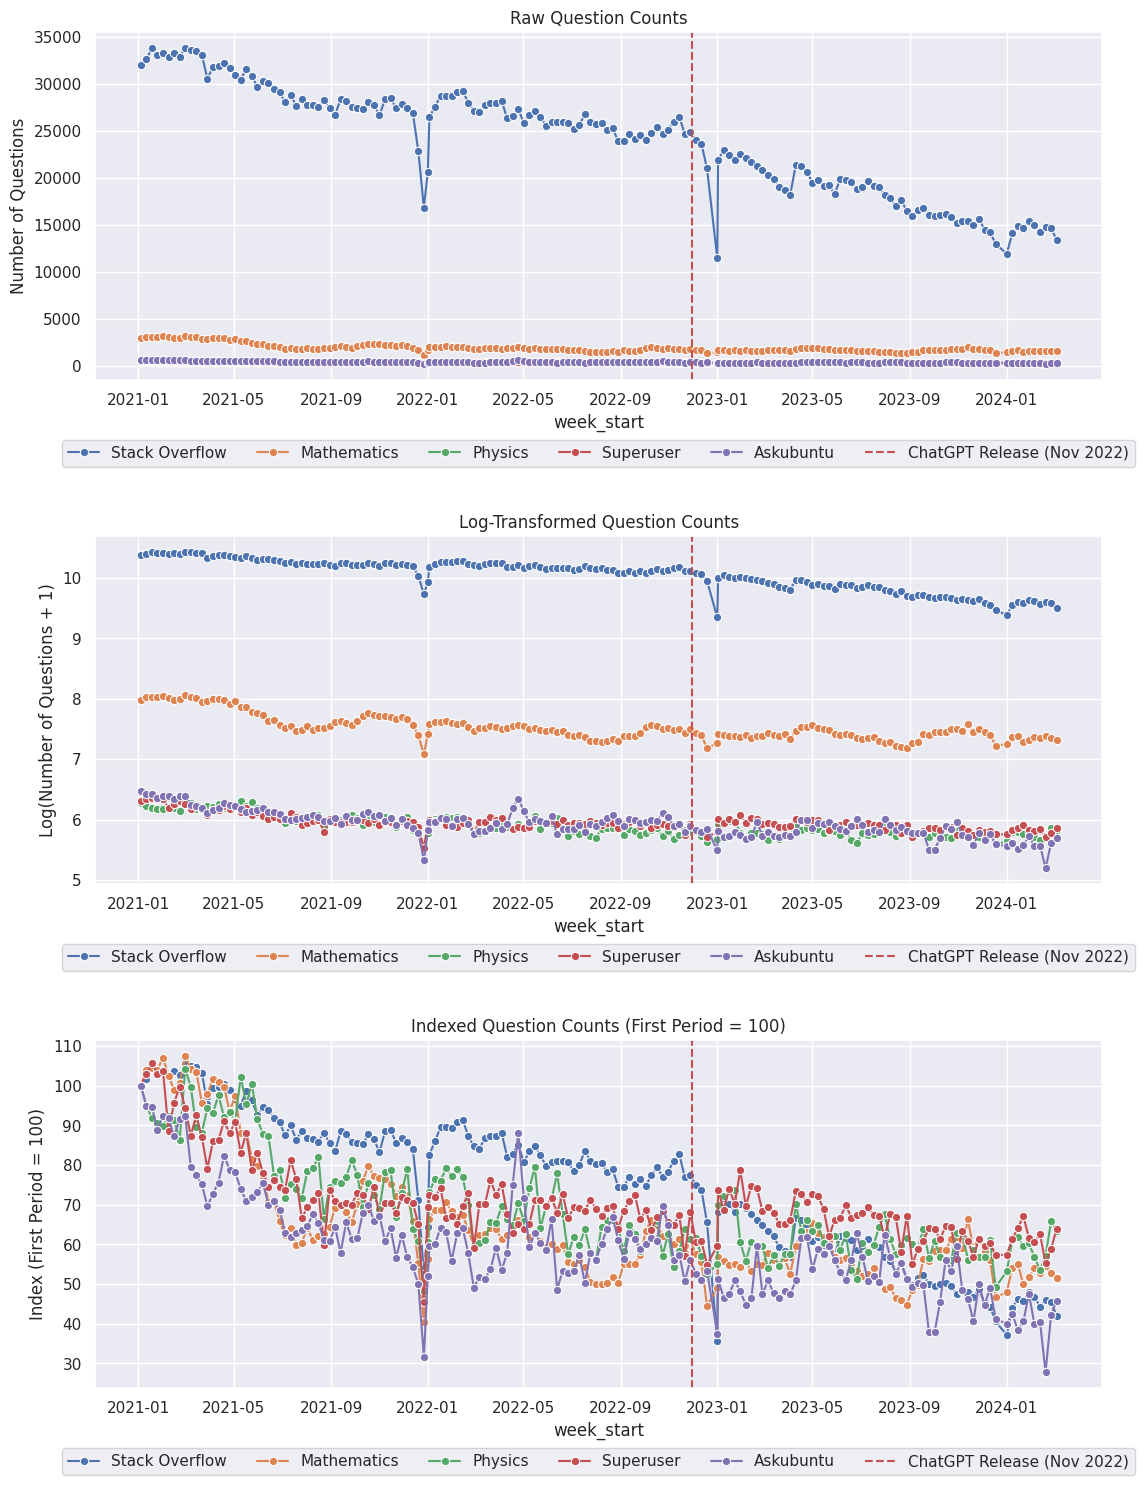

Parallel Trends Tests for Different Transformations:

Raw Counts:
time_trend:forum[T.Stack Overflow]: p = 0.0000 - Significant (non-parallel)
time_trend:forum[T.Mathematics]: p = 0.0052 - Significant (non-parallel)
time_trend:forum[T.Superuser]: p = 0.9075 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.9595 - Non-significant (parallel)

Log Counts:
time_trend:forum[T.Stack Overflow]: p = 0.0002 - Significant (non-parallel)
time_trend:forum[T.Mathematics]: p = 0.0400 - Significant (non-parallel)
time_trend:forum[T.Superuser]: p = 0.0081 - Significant (non-parallel)
time_trend:forum[T.Askubuntu]: p = 0.0729 - Non-significant (parallel)

Indexed Counts:
time_trend:forum[T.Stack Overflow]: p = 0.0027 - Significant (non-parallel)
time_trend:forum[T.Mathematics]: p = 0.0376 - Significant (non-parallel)
time_trend:forum[T.Superuser]: p = 0.0129 - Significant (non-parallel)
time_trend:forum[T.Askubuntu]: p = 0.0120 - Significant (non-parallel)


In [5]:
# Example usage (would be applied to actual data in real implementation)
all_forums_weekly_transformed = transform_for_parallel(all_forums_weekly)
visualize_transformations(all_forums_weekly_transformed)
parallel_tests = test_parallel_trends_transformed(all_forums_weekly_transformed)

In [6]:
# Pivot function for synthetic control
def prepare_data_for_synthetic_control(transformed_data):
    """
    Convert unpivoted data to pivoted format required for synthetic control.

    Parameters:
    -----------
    transformed_data : polars.DataFrame
        DataFrame with forums as values in a 'forum' column

    Returns:
    --------
    pandas.DataFrame
        Pivoted DataFrame with forums as columns
    """
    # Create a pivot table with all relevant metrics
    metrics = ["question_count"]
    if "log_question_count" in transformed_data.columns:
        metrics.append("log_question_count")
    if "indexed_count" in transformed_data.columns:
        metrics.append("indexed_count")

    # Create pivot tables for each metric and join them
    pivot_dfs = []

    for metric in metrics:
        pivot_df = transformed_data.pivot(
            index=["yearweek", "year", "week", "week_start"],
            columns="forum",
            values=metric,
        ).sort("week_start")

        # Rename columns to indicate the metric if we have multiple
        if len(metrics) > 1:
            pivot_df = pivot_df.rename(
                {
                    col: f"{col}_{metric}"
                    for col in pivot_df.columns
                    if col not in ["yearweek", "year", "week", "week_start"]
                }
            )

        pivot_dfs.append(pivot_df)

    # Join all pivot tables
    result = pivot_dfs[0]
    for df in pivot_dfs[1:]:
        result = result.join(
            df, on=["yearweek", "year", "week", "week_start"], how="left"
        )

    # Add treatment indicator
    treatment_date = datetime(2022, 11, 30)
    result = result.with_columns(
        pl.col("week_start").gt(treatment_date).alias("post_treatment")
    )

    return result.to_pandas()

In [7]:
# Then prepare for synthetic control and run it:
pivoted_data = prepare_data_for_synthetic_control(all_forums_weekly_transformed)
outcome_var = "Stack Overflow"
control_vars = ["Mathematics", "Physics", "Superuser", "Askubuntu"]
# If using transformed metrics:
log_outcome_var = "Stack Overflow_log_question_count"
log_control_vars = [f"{forum}_log_question_count" for forum in control_vars]
pre_treatment_mask = pivoted_data["week_start"] <= treatment_date
post_treatment_mask = pivoted_data["week_start"] > treatment_date

In [ ]:
# If using transformed metrics:
ind_outcome_var = "Stack Overflow_indexed_count"
ind_control_vars = [f"{forum}_indexed_count" for forum in control_vars]

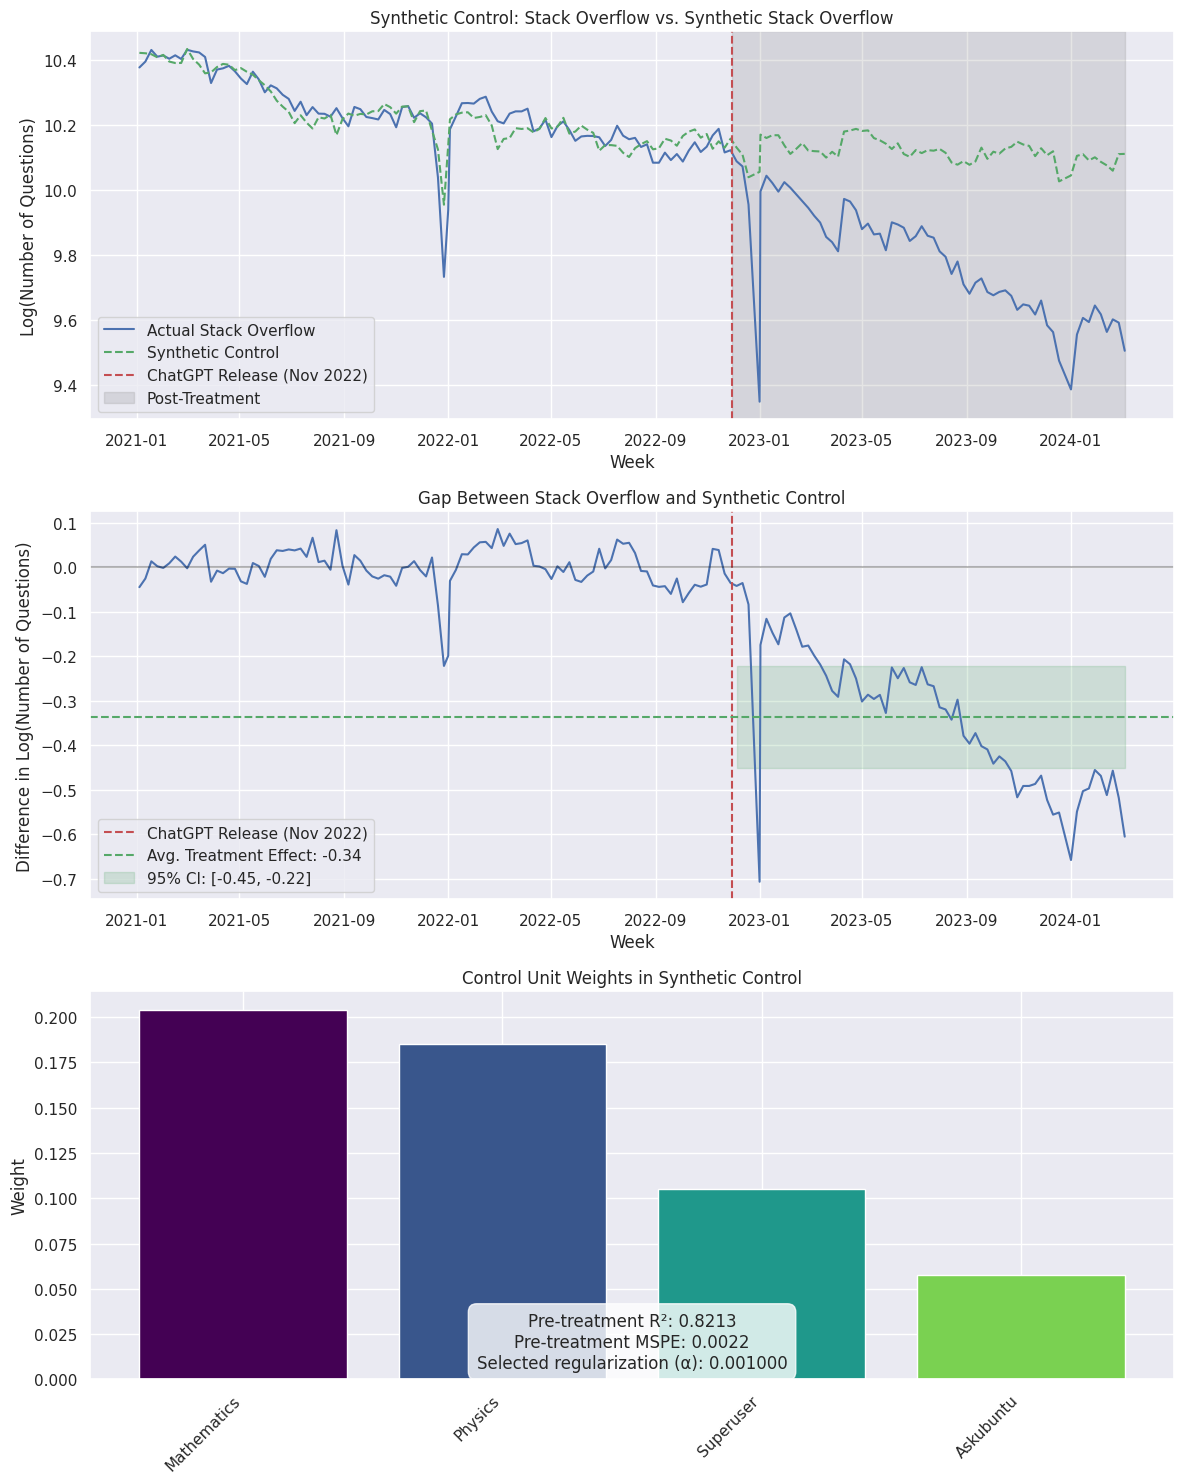

In [8]:
# Then run synthetic control with transformed data:
log_results = enhanced_synthetic_control(
    "Stack Overflow_log_question_count",
    log_control_vars,
    pivoted_data,
    treatment_date,
    pre_treatment_mask,
    post_treatment_mask,
    outcome_transform=None,  # Already transformed
)

vis = visualize_synthetic_control(
    pivoted_data, log_results, "Stack Overflow", transformation="log"
)

In [9]:
# Calculate t-statistic for the treatment effect
t_stat = log_results["att"] / log_results["se"]
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

T-Statistic: -5.7297, P-Value: 0.0000


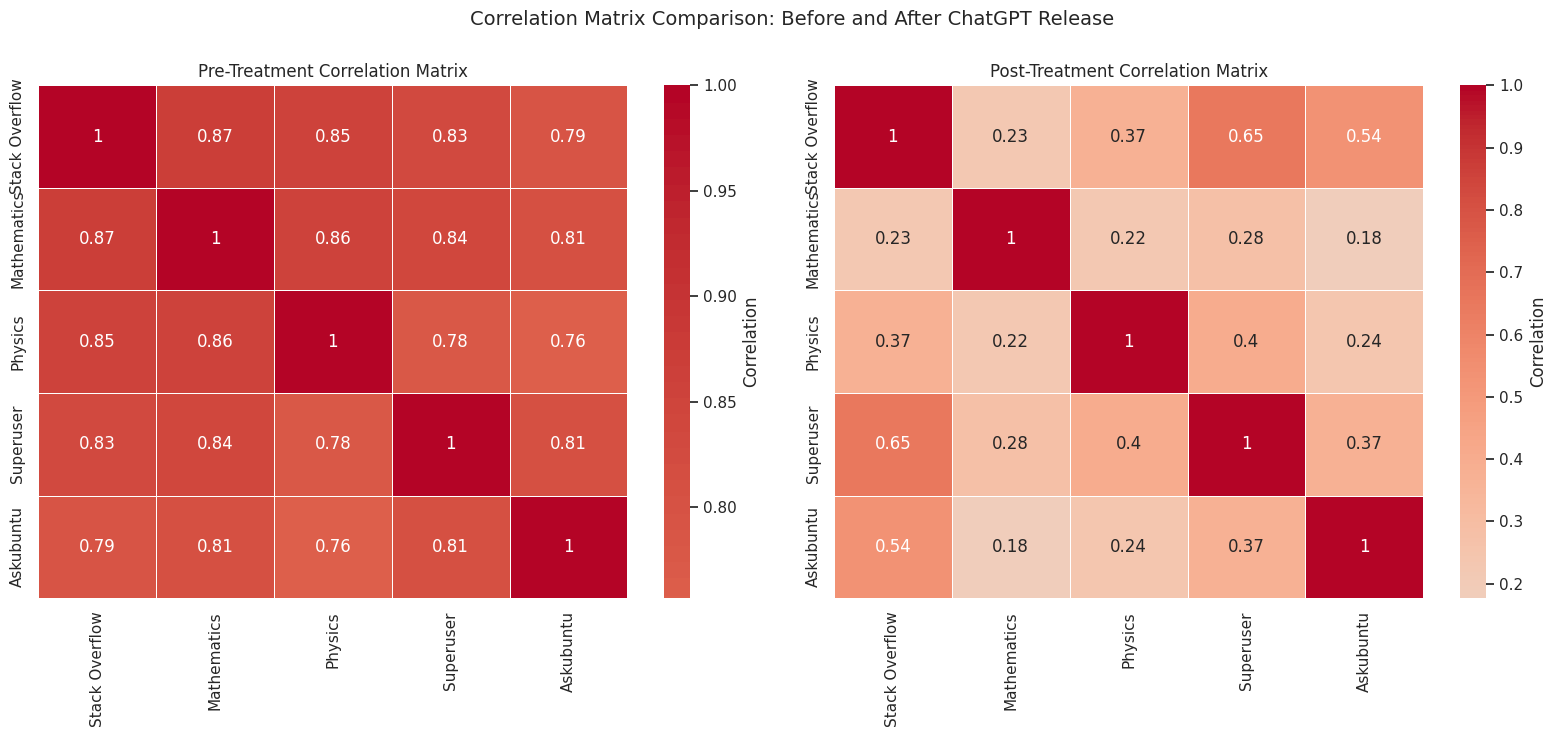

In [10]:
# Create subfigures for pre-treatment and post-treatment correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

all_forums_weekly_transformed1 = pl.from_pandas(pivoted_data)

# Specify which transformation to use
cat = (
    "_log_question_count"  # "_indexed_count"  # Use indexed count for better comparison
)
correlation_cols = [x for x in all_forums_weekly_transformed1.columns if cat in x]
labels = [x.replace(cat, "") for x in correlation_cols]

# Pre-treatment correlation matrix
pre_data = all_forums_weekly_transformed1.filter(
    pl.col("week_start") <= treatment_date
).drop_nans()
pre_corr = pre_data.select(correlation_cols).corr()

sns.heatmap(
    pre_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0],
)
axes[0].set_title("Pre-Treatment Correlation Matrix")

# Post-treatment correlation matrix
post_data = all_forums_weekly_transformed1.filter(
    pl.col("week_start") > treatment_date
).drop_nans()
post_corr = post_data.select(correlation_cols).corr()

sns.heatmap(
    post_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1],
)
axes[1].set_title("Post-Treatment Correlation Matrix")

plt.tight_layout()
plt.suptitle(
    "Correlation Matrix Comparison: Before and After ChatGPT Release",
    y=1.05,
    fontsize=14,
)
plt.show()

In [ ]:
# Data for pysynthdid
all_forums_weekly_transformed1 = all_forums_weekly_transformed.with_columns(
    pl.when(
        pl.col("week_start").gt(treatment_date) & pl.col("forum").eq("Stack Overflow")
    )
    .then(1)
    .otherwise(0)
    .alias("treatment")
)

all_forums_weekly_transformed1.write_parquet(
    "data/all_forums_weekly_transformed.parquet"
)

In [29]:
# Data for SynapeML
synapseml = all_forums_weekly_transformed.with_columns(
    pl.col("week_start").gt(treatment_date).alias("treatment"),
    pl.when(pl.col("forum").eq("Stack Overflow")).then(1).otherwise(0).alias("outcome"),
)
synapseml.write_parquet("data/synapseml.parquet")